In [24]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
from scipy.stats import chisquare
import itertools
import tqdm
import warnings
from scipy.optimize import OptimizeWarning
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import seaborn
import numpy as np
from scipy import stats
%matplotlib widget

In [25]:
warnings.simplefilter(action="ignore")

In [26]:
df = pd.read_excel(r"Detail.xlsx")
filelist = df["FileName"].dropna()

In [27]:
def curve(x,a,b):
        return a*(x**(-b))+1

def curve_shift(x,c):
        #return 0.39*((x-c)**(-1.19))+1 #aggregate
        #return 0.49*((x-c)**(-0.98))+1 #average
        return 0.64*((x-c)**(-1.48))+1 #David

def sigmoid(x, k2, k3, k1,k4):
        return k2-(k3 / (1 + np.exp(-k1*(x-k4))))

def sigmoid_0(x, k2, k1,k4):
        return k2-(k2 / (1 + np.exp(-k1*(x-k4))))

def sigmoid_plus_curve(x,a,b,k2, k3, k1,k4):
        return a*((x)**(-b))+k2-(k3 / (1 + np.exp(k1*(x-k4))))



def linear(x,a):
        return a*x 

def poly(x, k2, k3, k4,k5,k6):
        return np.polyval([k2, k3, k4,k5,k6],x)

In [28]:
def aggregate(path):
    col=["distance","normalized_distance","modulus","normalized_modulus","ContactRadius","A_cap"]
    delta=0.1
    filelist_ = os.listdir(glob.glob(path)[0])
    df_m=pd.DataFrame(columns=col)
    for x in filelist_:
        if ".csv" in x and "reduced_combined" not in x:
            df_=pd.read_csv(path+"/"+x)
            df_=df_[col]
            df_m = pd.concat([df_m, df_])
    x_range=np.arange(np.round(df_m["normalized_distance"].min())+1,np.round(df_m["normalized_distance"].max()),0.1)
    df_master = pd.DataFrame(
        columns=col+[x+"_std" for x in col])
    for x in x_range:
        temp=df_m[(x-delta<=df_m["normalized_distance"]) & (x+delta>=df_m["normalized_distance"])]
        df_temp=dict(temp.mean())
        df_temp2=dict(zip([x+"_std" for x in col], temp.std(ddof=0)))
        df_new=pd.DataFrame((df_temp|df_temp2),index=[0])
        df_master = pd.concat([df_new, df_master])
    df_master.to_csv(path+"/reduced_combined.csv")

In [29]:
for i in range(len(df)):
    if df['Temp'].iloc[i]==80.0 and df['Z Rate'].iloc[i]==250.0 and df['Point'].iloc[i]==128.0:
            try:
                path=f"Stats_CR/{int(df['InterphaseThickness'].iloc[i])}nm/{df['Probe'].iloc[i]}/{int(df['ForceSetpoint'].iloc[i])}"
                aggregate(path)
            except:
                pass

In [13]:
path=f"Stats_Ret/500nm/NCH/75"
aggregate(path)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

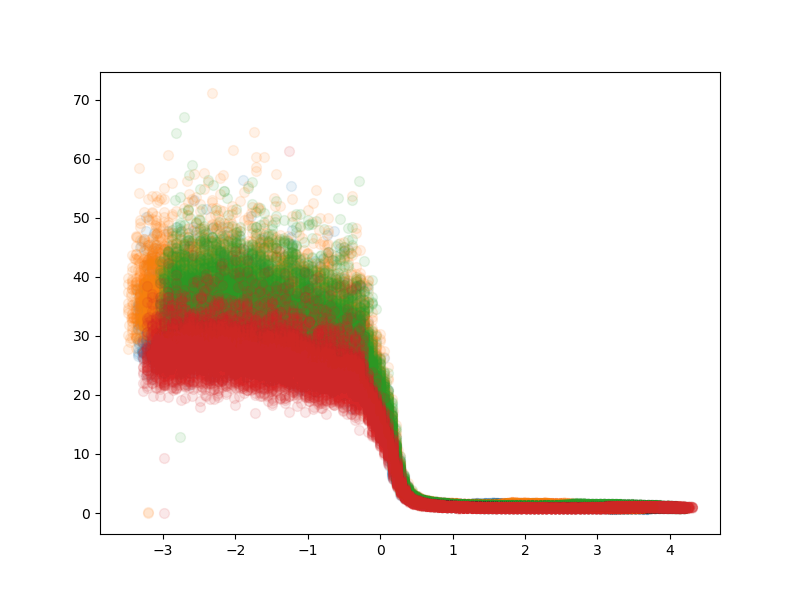

In [58]:
Thickness=[0]
Probe=["NCH"]
ForceSetpoint=[75]
lin=np.linspace(0,10,100)
lin_small=np.linspace(0,1,10)
comb=list(itertools.product(Thickness,Probe,ForceSetpoint))
dict_list=[]
cmap = plt.get_cmap('gist_rainbow')
mc_large=np.arange(1,30,0.1)
mc_small=np.arange(0,1,0.1)
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

for n,i in enumerate(comb):
    path=f"Stats_CR/{i[0]}nm/{i[1]}/{i[2]}"
    filelist_ = os.listdir(glob.glob(path)[0])
    df__=pd.DataFrame()
    popt_=[]
    df_fit_=pd.DataFrame()
    for m,x in enumerate(filelist_):
        if ".csv" in x and "reduced_combined" not in x:
                df_=pd.read_csv(path+"/"+x).dropna()
                

                df__ = pd.concat([df__, df_])
                Aff=np.array(df_["ContactRadius"]).mean()
                A_cap=np.array(df_["A_cap"]).mean()
                df_fit__=df_[(A_cap/Aff<df_["normalized_distance"] )]
                scatter=ax.scatter(x=df_["normalized_distance"], y=df_["normalized_modulus"],
                            label=f"{x}",s=50,alpha=0.1)
                #
                #ax.plot(lin,curve(lin,*popt))
                df_fit_= pd.concat([df_fit_, df__])
                # popt_.append(popt)
    popt_ave,pcov=sp.optimize.curve_fit(curve,df_fit_["normalized_distance"],df_fit_["normalized_modulus"],method="lm",maxfev=10000)
    # popt_ave=np.mean(np.array(popt_),axis=0)
    print(popt_ave)
    ax.plot(lin,curve(lin,*popt_ave),color="k")
    ax.set_ylim([0,10])
    ax.set_xlim([0,10])
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("$x/a_{FF} $",fontsize=20)
ax.set_ylabel("$E/E_{FF} $",fontsize=20)

def onselect(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    selected_points=df__[df__["distance"]>=x1]
    selected_points_=selected_points[selected_points["distance"]<=x2]

    print(f"Mean: ({(selected_points_['modulus']*1000*0.5625).mean()})")
    print(f"Standard Deviation: ({(selected_points_['modulus']*0.5625*1000).std()})")

# Rectangle selector
from matplotlib.widgets import RectangleSelector
rs = RectangleSelector(ax, onselect, useblit=True,
                       button=[1], minspanx=5, minspany=5, spancoords='pixels',
                       interactive=True)

# plt.show()

In [35]:


# # Sample arrays
array1 = [1.882929104,1.886374134,1.932769158,1.828741221,1.841573631,1.814218993]
array2 =[1.712478185,1.722699697,2.026657553,1.582012678,1.785851596,1.738584475,1.771038666]
array3 = [1.918,1.8781484,1.847666228,1.805369128,1.841901067,1.845341018]

f_stat, p_val = stats.f_oneway(array1,array2,array3)
print("One-Way ANOVA:", f_stat, p_val)

One-Way ANOVA: 2.7087975990070263 0.09700502091430056


In [30]:
Thickness=[50,150,500,1000]
real_thickness=[90,180,486,1168]

setpoint=[50,100]
Probe=["HQ300","HQ30030","NCH"]
probe_size=[15,30,300]


In [32]:

dict_all=[]
rel_int=[]
for k,T in enumerate(Thickness):
    dict_thick=[]
    for i,p in enumerate(Probe):
        for f,f_ in enumerate(setpoint):
            try:
                df_=pd.DataFrame()
                path=f"Stats_CR/{T}nm/{p}/{f_}"
                filelist_ = os.listdir(glob.glob(path)[0])
                Aff_=[]
                for x in filelist_:
                    print(x)
                    if "reduced_combined.csv" in x:
                        df_=pd.read_csv(path+"/"+x).dropna()
                        Aff=np.array(df_["ContactRadius"]).mean()
                        A_cap=np.array(df_["A_cap"]).mean()
                        df_["diff"]=df_["normalized_modulus"]-curve_shift(df_["normalized_distance"],0)
                        df_fit_=df_[(A_cap/Aff<df_["normalized_distance"] ) & (df_["diff"]<1.1 )]
                        param_all=[]
                        score=[]
                        param_mean=[0.8,1,real_thickness[k]/Aff]
                        popt_,pcov_=sp.optimize.curve_fit(sigmoid_0,df_fit_["normalized_distance"],df_fit_["diff"],method="lm",maxfev=10000,p0=param_mean)
                        for i in tqdm.tqdm(range(500)):
                            try:
                                ind = np.random.choice(np.arange(df_fit_.shape[0]), df_fit_.shape[0])
                                x=df_fit_.iloc[ind]["normalized_distance"]
                                y=df_fit_.iloc[ind]["diff"]
                                popt_sig,pcov_sig=sp.optimize.curve_fit(sigmoid_0,x,y,method="lm",maxfev=10000,p0=popt_)
                                param_all.append(popt_sig.tolist())
                                
                            except RuntimeError:
                                print("passed")
                                pass
                

                rel_int.append(real_thickness[k]/Aff)
                param_all=np.array(param_all)[np.array(param_all)[:, 0].argsort()]
                l_05=param_all[24,:]
                l_95=param_all[475,:]
                score=(((np.sum((df_fit_["diff"] - sigmoid_0(df_fit_["normalized_distance"], *popt_)) ** 2))/len(df_fit_["diff"])))
                E_lower=sigmoid_0(0,*l_05)
                E_upper=sigmoid_0(0,*l_95)
                print(f"{real_thickness[k]/Aff}")
                print(popt_[2])
                print(score)
                fit_score=sigmoid_0(0,*popt_)
                err=np.abs(popt_[2]*Aff-real_thickness[k])/real_thickness[k]
                dict_={"path":path+"/reduced_combined.csv",
                    "Aff":Aff,
                    "sigmoid_fit":popt_,
                    "λint/aff":real_thickness[k]/Aff,
                    "λpred/aff" : popt_[2],
                    "lower" :l_05[2],
                    "upper" : l_95[2],
                    "fit_score" :fit_score,
                    "RMS":score,
                    "err" : err,
                    "E_lower" : E_lower,
                    "E_upper" : E_upper,
                    "Force":f_,
                    "Probe":p,
                    "Int":T}
                dict_all.append(dict_)
            except:
                pass


df=pd.DataFrame(dict_all)
df.to_csv("fit_cr_David_ForceSetpoint.csv")

#fig.savefig(fname=f"{Thickness[0]},{ForceSetpoint[0]}nN.png")



240204_2.5_HQ300_80_50_500_01_cr.csv
240204_2.5_HQ300_80_50_500_02_cr.csv
240204_2.5_HQ300_80_50_500_03_cr.csv
240204_2.5_HQ300_80_50_500_04_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:25<00:00, 19.60it/s]


2.60714415573007
0.6980592477925923
0.0009169881638209179
240204_2.5_HQ300_80_100_500_01_cr.csv
240204_2.5_HQ300_80_100_500_02_cr.csv
240204_2.5_HQ300_80_100_500_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:30<00:00, 16.25it/s]


2.1807503129205874
1.2066301573762204
0.00040552301713815307
240204_2.5_HQ30030_80_50_500_02_cr.csv
240204_2.5_HQ30030_80_50_500_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:13<00:00, 38.03it/s]


2.0017194537905207
1.2280320161868756
0.0005429469691115572
240204_2.5_HQ30030_80_100_500_01_cr.csv
240204_2.5_HQ30030_80_100_500_02_cr.csv
240204_2.5_HQ30030_80_100_500_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:11<00:00, 45.14it/s]


1.7475783860031144
1.4655339567508172
0.0003587301973039628
240204_2.5_NCH_80_50_01_cr.csv
240204_2.5_NCH_80_50_02_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:35<00:00, 14.02it/s]


0.5934581011190087
-11.067292019523892
0.0005464643656637721
240204_2.5_NCH_80_100_01_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [02:08<00:00,  3.90it/s]


0.5117395905059798
0.8359138716466156
0.002772537271845647
240209_5.0_HQ300_80_50_01_cr.csv
240209_5.0_HQ300_80_50_02_cr.csv
240209_5.0_HQ300_80_50_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:12<00:00, 38.92it/s]


4.965196622015655
4.861485256356065
0.0015979207365053032
240209_5.0_HQ300_80_100_01_cr.csv
240209_5.0_HQ300_80_100_02_cr.csv
240209_5.0_HQ300_80_100_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:15<00:00, 32.19it/s]


4.738506537376121
3.990788087999257
0.0026674979348180632
240209_5.0_HQ30030_80_50_01_cr.csv
240209_5.0_HQ30030_80_50_02_cr.csv
240209_5.0_HQ30030_80_50_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:13<00:00, 35.95it/s]


3.4562575847797494
3.081244615911016
0.0016708244173971028
240209_5.0_HQ30030_80_100_01_cr.csv
240209_5.0_HQ30030_80_100_02_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:37<00:00, 13.43it/s]


3.3543825029049947
1.197484402491424
0.005470227076329779
240209_5.0_NCH_80_50_01_cr.csv
240209_5.0_NCH_80_50_02_cr.csv
240209_5.0_NCH_80_50_03_cr.csv
240209_5.0_NCH_80_50_04_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:24<00:00, 20.14it/s]


1.2779675921435147
1.5347463722304473
0.005344972659909067
240209_5.0_NCH_80_100_01_cr.csv
240209_5.0_NCH_80_100_02_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [02:12<00:00,  3.79it/s]


1.1485903058481512
3.479302409010974
0.001508565644766138
240209_10.0_HQ300_80_50_01_cr.csv
240209_10.0_HQ300_80_50_02_cr.csv
240209_10.0_HQ300_80_50_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:25<00:00, 19.36it/s]


13.152730044172921
13.527065186468716
0.0030904080680908773
240209_10.0_HQ300_80_100_01_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:13<00:00, 36.56it/s]


11.3535819873693
12.086066981719757
0.0008179748340753178
240209_10.0_HQ30030_80_50_01_cr.csv
240209_10.0_HQ30030_80_50_02_cr.csv
240209_10.0_HQ30030_80_50_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:21<00:00, 23.48it/s]


9.762251731637996
8.849023748575776
0.0036730766756445316
240209_10.0_HQ30030_80_100_01_cr.csv
240209_10.0_HQ30030_80_100_02_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:18<00:00, 27.43it/s]


9.014100838101786
8.005748067969638
0.0031470829670368554
240209_10.0_NCH_80_50_01_cr.csv
240209_10.0_NCH_80_50_02_cr.csv
240209_10.0_NCH_80_50_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:08<00:00, 60.01it/s]


3.2875979984560693
3.2912659560273987
0.0013424458909453557
240209_10.0_NCH_80_100_01_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:09<00:00, 50.26it/s]


2.8490496133265184
2.951485416847142
0.0019250468174302705
240210_20.0_HQ300_80_50_01_cr.csv
240210_20.0_HQ300_80_50_02_cr.csv
240210_20.0_HQ300_80_50_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:15<00:00, 32.61it/s]


29.322130716423757
23.542188593816423
0.002082694607545471
240210_20.0_HQ300_80_100_01_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:18<00:00, 26.81it/s]


26.14019595836762
20.62577454013858
0.0030076385568641117
240210_20.0_HQ30030_80_50_01_cr.csv
240210_20.0_HQ30030_80_50_02_cr.csv
240210_20.0_HQ30030_80_50_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:17<00:00, 27.86it/s]


19.693104129052497
15.412119185462828
0.0018598525120667282
240210_20.0_NCH_80_50_01_cr.csv
240210_20.0_NCH_80_50_02_cr.csv
240210_20.0_NCH_80_50_03_cr.csv
reduced_combined.csv


100%|██████████| 500/500 [00:10<00:00, 48.26it/s]


6.833922251987426
5.739191434187312
0.00317550124967241


In [6]:
def chi_score_difference(X,y,curve_):

    X_all=np.array(sum(X,[]),dtype=np.longdouble)
    y_all=np.array(sum(y,[]),dtype=np.longdouble)
    popt_all,pcov_all=sp.optimize.curve_fit(curve_,X_all, y_all,method="dogbox")
    y_pred_all=curve_(X_all,*popt_all)
    try:
        chi2_all,p_val=chisquare(f_obs=y_all, f_exp=y_pred_all)
    except:
        chi2_all=0
    if chi2_all<0:
        print(chi2_all,p_val)
        val=0
    else:
        val=  chi2_all
    return val

In [7]:
def fit_polynomial(x, y, degree):
    # Generates polynomial features
    X = np.vander(x, degree + 1)
    # Fit model
    model = sm.OLS(y, X).fit()
    return model

In [8]:
def MSD_difference(X,y,degree):

    X_all=np.array(sum(X,[]))
    y_all=np.array(sum(y,[]))
    model = fit_polynomial(X_all, y_all, degree)
    aic=model.aic

    y_pred_all=model.predict(np.vander(X_all, degree + 1))
    MSD_all=mean_squared_error(y_all,y_pred_all)
    val=  MSD_all
    return val,aic

In [9]:
Thickness=[50,150,500,1000]
Probe=["HQ300","HQ30030","NCH"]


rel_int_thickness=np.arange(0,1500,1)

int_pred_all=[]
chi_all=[]
aic_all=[]


for T in Thickness:
    int_pred=[]
    chi_score=[]
    X_=[]
    Y_observe=[]
    df_list=[]
    aic_=[]
    for p in Probe:
        path=f"Stats_CR/{T}nm/{p}/75"
        filelist_ = os.listdir(glob.glob(path)[0])
        df__=pd.DataFrame()
        for x in filelist_:
            if ".csv" in x and "reduced_combined" not in x:
                df_=pd.read_csv(path+"/"+x,index_col=0).dropna()
                df_["diff"]=df_["normalized_modulus"]-curve(df_["normalized_distance"],0.64,1.48)
                df__=pd.concat([df__,df_])

        # df__=pd.read_csv(f"Stats_Ret/Combined_DF/{T}nm_{p}_75.csv").dropna()
        df__=df__[(1<=df__["normalized_distance"] ) ]
        df__=df__[(1.1>=df__["diff"] )]
        df__=df__._get_numeric_data()
        df_list.append(df__)
        X_.append(df__["normalized_distance"].to_list())
        Y_observe.append(df__["diff"].to_list())
    init_Score,_=MSD_difference(X_,Y_observe,8)
    for r in tqdm.tqdm(rel_int_thickness):
        X_norm=[((df["distance"]-r)/df["ContactRadius"]).to_list() for df in df_list]

        try:
            shift_Score,aic__=MSD_difference(X_norm,Y_observe,8)
            val=1/shift_Score
            int_pred.append(r)
            chi_score.append(val)
            aic_.append(aic__)
            
        except:
            pass
   
    int_pred_all.append(int_pred)
    chi_all.append(chi_score)
    print(f"{T} nm FINISHED!")


100%|██████████| 1500/1500 [02:45<00:00,  9.04it/s]


50 nm FINISHED!


100%|██████████| 1500/1500 [03:35<00:00,  6.97it/s]


150 nm FINISHED!


100%|██████████| 1500/1500 [03:03<00:00,  8.16it/s]


500 nm FINISHED!


100%|██████████| 1500/1500 [03:09<00:00,  7.91it/s]

1000 nm FINISHED!


In [16]:
df=pd.DataFrame(np.array(chi_all).T)

In [18]:
df.to_csv("reduced_RMS.csv")

In [400]:
aic_all_=np.array(aic_all)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

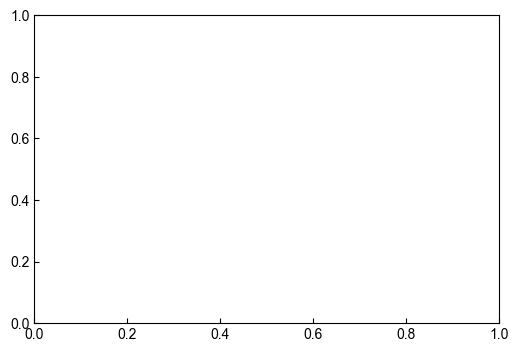

In [401]:
#label=["180nm\n 5 wt%","580nm \n 10 wt%", "1000nm \n 20 wt%"]

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
for i in range(0,9):
    ax.plot(rel_int_thickness,aic_all_[i,0,:],label=f"{i+1} th degree",c=color_list[i])
ax.set_xlabel("predicted interphase thickness [nm]",fontsize=15)
ax.set_ylabel("AIC",fontsize=15)
#ax.set_yscale("log")
ax.legend(loc="upper left")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

NameError: name 'color_list' is not defined

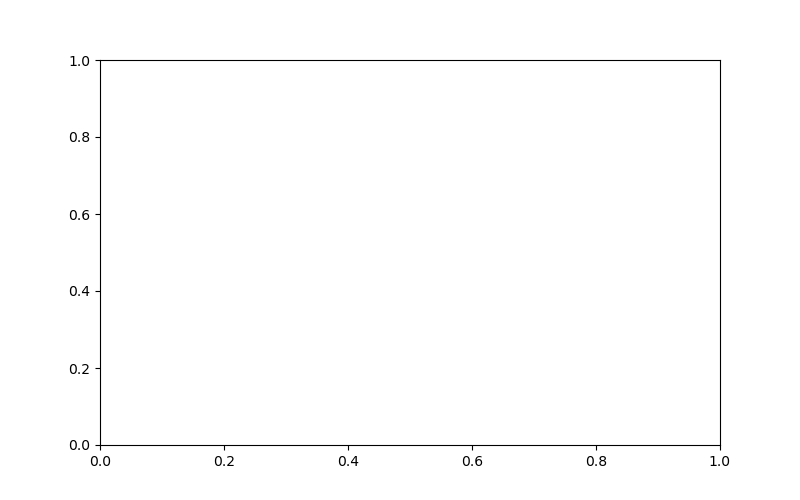

In [19]:
label=["90nm\n 2.5 wt%","180nm\n 5 wt%","486nm \n 10 wt%", "1168nm \n 20 wt%"]

fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)
for i,n in enumerate(int_pred_all):
    ax.plot(int_pred_all[i],np.array(chi_all[i]),label=f"{label[i]}",c=color_list[i])
    print(f"{int_pred_all[i][np.array(chi_all[i]).argmax()]}")
ax.set_xlabel("predicted interphase thickness [nm]",fontsize=15)
ax.set_ylabel("Reduced RMS",fontsize=15)
#ax.set_yscale("log")
ax.legend(loc="upper right")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1.05), ncol=4,fontsize=13,frameon = False)
fig.savefig(fname=f"reduced_RMS.png",dpi=800,bbox_inches="tight",pad_inches=0)

#fig.savefig(fname="reduced_RMS.svg")